# Home assignment 1: Kalman Filter

Imagine a robot. Robot state is described with the following parameters

1. $x$, $y$ - robot coordinates,
2. $V_x$, $V_y$ - velocities.

We can only measure the coordinates of the robot, which should be reflected in the $ H $ matrix.

In this homework assignment:
- Fill in the matrices for the Kalman filter correctly.
- For all three experiments, visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time.
- For all three experiments, visualize the dependence of each component of the gain matrix ($ K $) over time.
     - What does the dynamics of changes in its components say?
- How much does the velocity uncertainty decrease as a result of each experiment?

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

You could edit `kalman_filter` function if you need more info about the process e.g. `x` values over time and so on

_Hint:_ to define matrices below function [np.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) is very handy

In [2]:
dt = 0.1

# initial covariance matrix: 0. for positions x and y, 1000 for the two velocities
E = np.diag([0, 0, 1000, 1000])

# next state function: 4D
F = np.matrix([
    [1., 0., dt, 0.],
    [0., 1., 0., dt],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
])

# measurement function: reflect the fact that we observe x and y but not the two velocities
H = np.diag([1., 1., 0., 0.])

# measurement uncertainty: use 2x2 matrix with 0.1 as main diagonal
R = np.diag(np.ones(4)) * 0.1

# 4D identity matrix
I = np.diag(np.ones(4))

In [3]:
def kalman_filter(x, E=E, F=F, H=H, R=R, I=I):
    """Apply Kalman filter to sequence

    Args:
        x: initial state space configuration (location and velocity)
        E: initial covariance matrix
    """
    hist = defaultdict(list)
    for measurement in measurements:
        # prediction
        x = (F @ x) + u
        E = F @ E @ F.T

        # measurement update
        Z = np.array([*measurement, 0., 0.])[None]
        S = H @ E @ H.T + R
        K = E @ H.T @ np.linalg.inv(S)
        
        x = x + (K @ (Z.T - (H @ x)))
        E = (I - (K @ H)) @ E
        hist['k_gain'].append(K)
        hist['state'].append(x)
        hist['cov'].append(E)
        
        print(f"x= \n{x}")
        print(f"E= \n{E}")

    return hist

## First experiment

In [4]:
measurements = [[5.0, 10.0], [6.0, 8.0], [7.0, 6.0], [8.0, 4.0], [9.0, 2.0], [10.0, 0.0]]
initial_xy = [4.0, 12.0]


# initial robot state (location and velocity)
x = np.array([[initial_xy[0]], [initial_xy[1]], [0.0], [0.0]])
# external motion applied to the robot
u = np.array([[0.0], [0.1], [0.0], [0.0]])

In [5]:
log = kalman_filter(x)

x= 
[[  4.99009901]
 [ 10.02079208]
 [  9.9009901 ]
 [-20.79207921]]
E= 
[[0.0990099  0.         0.99009901 0.        ]
 [0.         0.0990099  0.         0.99009901]
 [0.99009901 0.         9.9009901  0.        ]
 [0.         0.99009901 0.         9.9009901 ]]
x= 
[[  5.99600798]
 [  8.00838323]
 [  9.98003992]
 [-20.95808383]]
E= 
[[0.07984032 0.         0.3992016  0.        ]
 [0.         0.07984032 0.         0.3992016 ]
 [0.3992016  0.         1.99600798 0.        ]
 [0.         0.3992016  0.         1.99600798]]
x= 
[[  6.99785867]
 [  6.00449679]
 [  9.99286224]
 [-20.98501071]]
E= 
[[0.06423983 0.         0.21413276 0.        ]
 [0.         0.06423983 0.         0.21413276]
 [0.21413276 0.         0.71377587 0.        ]
 [0.         0.21413276 0.         0.71377587]]
x= 
[[  7.99866711]
 [  4.00279907]
 [  9.99666778]
 [-20.99300233]]
E= 
[[0.05331556 0.         0.1332889  0.        ]
 [0.         0.05331556 0.         0.1332889 ]
 [0.1332889  0.         0.33322226 0.        ]


Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

_(It's a good idea to write a function for this, so you could reuse it in the next experiment)_

In [6]:
def plot_state(state_log, cov_log, measurements):
    names = ['x', 'y', 'vel_x', 'vel_y']
    state_hist = np.array(state_log).squeeze().T
    cov_hist = np.array([np.diag(c) for c in cov_log]).T
    measured_hist = np.array(measurements).T
    time_hist = range(len(state_log))
    
    plot_iter = zip(state_hist, cov_hist, [*measured_hist, None, None], names)
    plt.figure(figsize=(10, 5))
    for i, (s_hist, err_hist, m_hist, name) in enumerate(plot_iter):
        plt.subplot(2, 2, i + 1)
        plt.errorbar(time_hist, s_hist, yerr=err_hist, label=f'expected {name}')
        
        if m_hist is not None:
            plt.plot(time_hist, m_hist, label=f'measured {name}')
        
    plt.legend()
    plt.tight_layout()
    
def plot_gain(gain_log):
    assert_gain_structure(gain_log)
    x_gain = np.array(gain_log)[:, 0, 0]
    vel_x_gain = np.array(gain_log)[:, 2, 0]
    time_hist = range(len(gain_log))
    
    plt.figure(figsize=(10, 2.5))
    plt.subplot(1, 2, 1)
    plt.plot(time_hist, x_gain, label='K for x')
    print(f'min x gain: {min(x_gain)}')
    
    plt.subplot(1, 2, 2)
    plt.plot(time_hist, vel_x_gain, label='K for vel_x')
    print(f'min vel x gain: {min(vel_x_gain)}')
    
    plt.legend()
    plt.tight_layout
    

def assert_gain_structure(gain_log):
    x_gain = np.array(gain_log)[:, ::2, 0]
    y_gain = np.array(gain_log)[:, 1::2, 1]
    assert np.allclose(x_gain, y_gain)

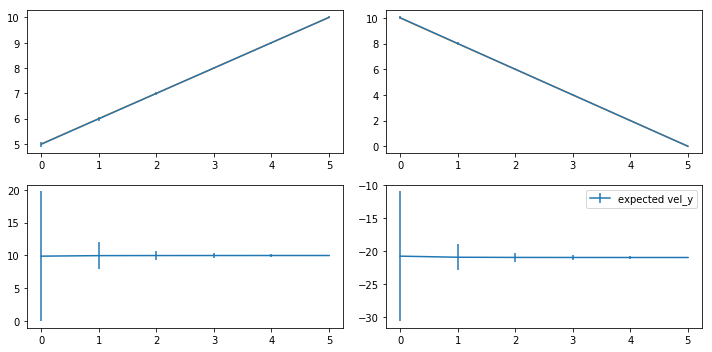

In [7]:
plot_state(log['state'], log['cov'], measurements)

Visualize the components of the $ K $ matrix below

min x gain: 0.3955609273706197
min vel x gain: 0.6592682122843708


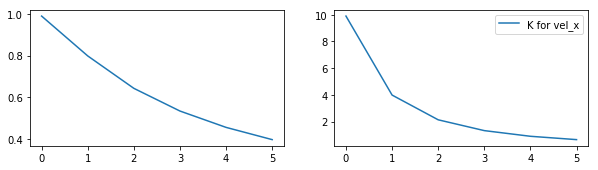

In [8]:
plot_gain(log['k_gain'])

## Second experiment

In [9]:
measurements = [[1.0, 4.0], [6.0, 0.0], [11.0, -4.0], [16.0, -8.0]]
initial_xy = [-4.0, 8.0]

# initial robot state (location and velocity)
x = np.array([[initial_xy[0]], [initial_xy[1]], [0.0], [0.0]])
# external motion applied to the robot
u = np.array([[0.0], [0.1], [0.0], [0.0]])

In [10]:
log = kalman_filter(x, E)

x= 
[[  0.95049505]
 [  4.04059406]
 [ 49.5049505 ]
 [-40.59405941]]
E= 
[[0.0990099  0.         0.99009901 0.        ]
 [0.         0.0990099  0.         0.99009901]
 [0.99009901 0.         9.9009901  0.        ]
 [0.         0.99009901 0.         9.9009901 ]]
x= 
[[ 5.98003992e+00]
 [ 1.63672655e-02]
 [ 4.99001996e+01]
 [-4.09181637e+01]]
E= 
[[0.07984032 0.         0.3992016  0.        ]
 [0.         0.07984032 0.         0.3992016 ]
 [0.3992016  0.         1.99600798 0.        ]
 [0.         0.3992016  0.         1.99600798]]
x= 
[[ 10.98929336]
 [ -3.99122056]
 [ 49.96431121]
 [-40.97073519]]
E= 
[[0.06423983 0.         0.21413276 0.        ]
 [0.         0.06423983 0.         0.21413276]
 [0.21413276 0.         0.71377587 0.        ]
 [0.         0.21413276 0.         0.71377587]]
x= 
[[ 15.99333555]
 [ -7.99453515]
 [ 49.98333889]
 [-40.98633789]]
E= 
[[0.05331556 0.         0.1332889  0.        ]
 [0.         0.05331556 0.         0.1332889 ]
 [0.1332889  0.         0.33322226 

Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

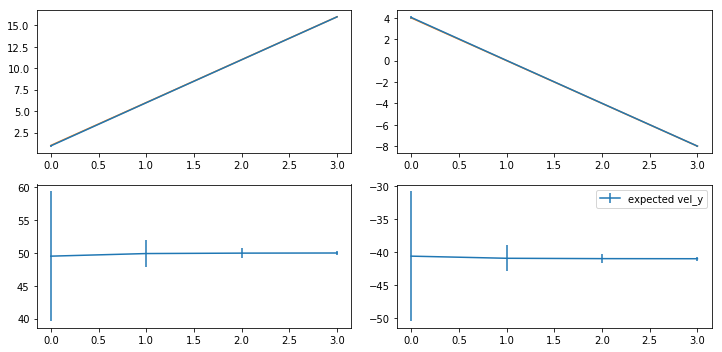

In [11]:
plot_state(log['state'], log['cov'], measurements)

Visualize the components of the $ K $ matrix below

min x gain: 0.5331556147950691
min vel x gain: 1.332889036987678


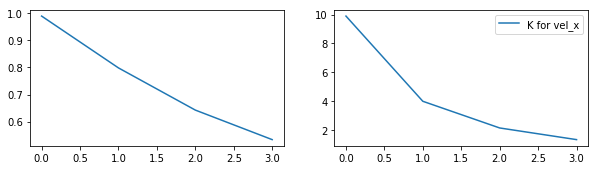

In [12]:
plot_gain(log['k_gain'])

## Third Experiment

In [13]:
measurements = [[1.0, 17.0], [1.0, 15.0], [1.0, 13.0], [1.0, 11.0]]
initial_xy = [1.0, 19.0]

dt = 0.1

# initial robot state (location and velocity)
x = np.array([[initial_xy[0]], [initial_xy[1]], [0.0], [0.0]])
# external motion applied to the robot
u = np.array([[0.0], [0.1], [0.0], [0.0]])

In [14]:
log = kalman_filter(x, E)

x= 
[[  1.        ]
 [ 17.02079208]
 [  0.        ]
 [-20.79207921]]
E= 
[[0.0990099  0.         0.99009901 0.        ]
 [0.         0.0990099  0.         0.99009901]
 [0.99009901 0.         9.9009901  0.        ]
 [0.         0.99009901 0.         9.9009901 ]]
x= 
[[  1.        ]
 [ 15.00838323]
 [  0.        ]
 [-20.95808383]]
E= 
[[0.07984032 0.         0.3992016  0.        ]
 [0.         0.07984032 0.         0.3992016 ]
 [0.3992016  0.         1.99600798 0.        ]
 [0.         0.3992016  0.         1.99600798]]
x= 
[[  1.        ]
 [ 13.00449679]
 [  0.        ]
 [-20.98501071]]
E= 
[[0.06423983 0.         0.21413276 0.        ]
 [0.         0.06423983 0.         0.21413276]
 [0.21413276 0.         0.71377587 0.        ]
 [0.         0.21413276 0.         0.71377587]]
x= 
[[  1.        ]
 [ 11.00279907]
 [  0.        ]
 [-20.99300233]]
E= 
[[0.05331556 0.         0.1332889  0.        ]
 [0.         0.05331556 0.         0.1332889 ]
 [0.1332889  0.         0.33322226 0.        ]


Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

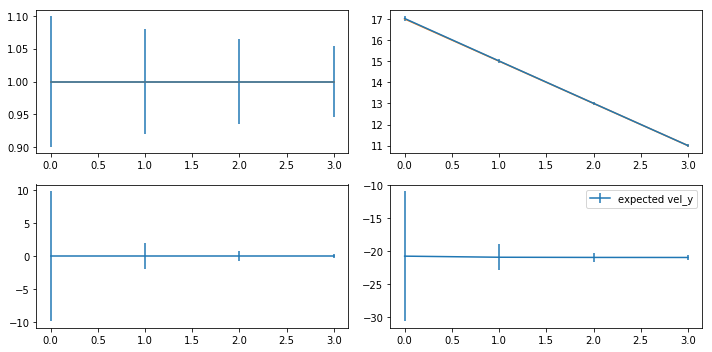

In [15]:
plot_state(log['state'], log['cov'], measurements)

Visualize the components of the $ K $ matrix below

min x gain: 0.5331556147950691
min vel x gain: 1.332889036987678


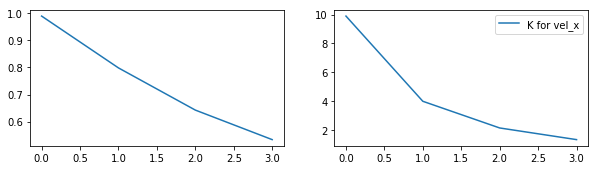

In [16]:
plot_gain(log['k_gain'])

## Conclusions

Don't forget to put your thoughts on the experiments above.

Questions to stimulate thoughts could be found in the beginning of the notebook =)

По формулам выходит так, что изменение матрицы ковариации зависит только от гипперпараметров алгоритмов и не зависит от измерений 

In [17]:
def iterate_gain(n, E=E, F=F, H=H, R=R, I=I):
    log = defaultdict(list)
    for _ in range(n):
        E = F @ E @ F.T
        S = H @ E @ H.T + R
        K = E @ H.T @ np.linalg.inv(S)
        E = (I - (K @ H)) @ E
        log['gain'].append(K)
        log['s'].append(S)
        log['cov'].append(E)
    return log


min x gain: 0.029555193451895088
min vel x gain: 0.002955519345189895


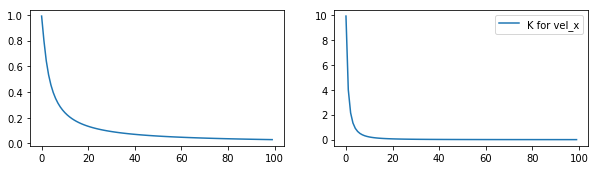

In [18]:
gain_change = iterate_gain(100)

plot_gain(gain_change['gain'])

С текущими параметрами в некоторый момент ожидаемое состояние перестанет зависить от измеренного состояния. Т.о. в какой-то момент мы будем полностью полагаться на модель

In [19]:
for i in np.geomspace(0.001, 10000, 8):
    gain_log = iterate_gain(100, R=np.diag(np.ones(4)*i))['gain']
    x_gain = np.array(gain_log)[:, 0, 0]
    vel_x_gain = np.array(gain_log)[:, 2, 0]
    print(f'R_scale: {i}\t\t', end='')
    print(f'min x gain: {min(x_gain):.4f}\t', end='')
    print(f'min vel x gain: {min(vel_x_gain):.4f}')

R_scale: 0.001		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 0.01		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 0.1		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 1.0		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 10.0		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 100.0		min x gain: 0.0296	min vel x gain: 0.0030
R_scale: 1000.0		min x gain: 0.0099	min vel x gain: 0.0030
R_scale: 10000.0		min x gain: 0.0010	min vel x gain: 0.0029


In [20]:
for i in np.geomspace(0.001, 10000, 8):
    gain_log = iterate_gain(100, E=np.diag(np.ones(4)*i))['gain']
    x_gain = np.array(gain_log)[:, 0, 0]
    vel_x_gain = np.array(gain_log)[:, 2, 0]
    print(f'R_scale: {i}\t\t', end='')
    print(f'min x gain: {min(x_gain):.4f}\t', end='')
    print(f'min vel x gain: {min(vel_x_gain):.4f}')

R_scale: 0.001		min x gain: 0.0100	min vel x gain: 0.0010
R_scale: 0.01		min x gain: 0.0363	min vel x gain: 0.0050
R_scale: 0.1		min x gain: 0.0390	min vel x gain: 0.0058
R_scale: 1.0		min x gain: 0.0394	min vel x gain: 0.0059
R_scale: 10.0		min x gain: 0.0394	min vel x gain: 0.0059
R_scale: 100.0		min x gain: 0.0394	min vel x gain: 0.0059
R_scale: 1000.0		min x gain: 0.0394	min vel x gain: 0.0059
R_scale: 10000.0		min x gain: 0.0394	min vel x gain: 0.0059


Изменение значений на диагонали $R$ и $E$ на минимум $K$ не особо повлияло. Насколько я понимаю, это связано с отсутствием матрицы $Q$. Также из-за этого (наверное) и затухает uncertainty, что конечно неестественно.